# Hand Gesture Recognition: Neural Network Training and Evaluation

This notebook details the process of training and evaluating a neural network for hand gesture recognition. The primary goal is to build a robust classifier that can accurately identify different hand gestures from landmark data extracted using MediaPipe.

The process involves:
1.  **Loading Preprocessed Data**: We use datasets of hand landmarks generated by the `data_generation.ipynb` notebook.
2.  **Hyperparameter Tuning**: A systematic search is performed to find the optimal set of hyperparameters for our neural network model.
3.  **Model Training**: The model is trained on the landmark data.
4.  **Evaluation**: The trained model's performance is rigorously evaluated using various metrics and visualizations.
5.  **Saving the Best Model**: The best-performing model is saved for real-time inference in the main application.

### Table of Contents
1. [Setup and Dependencies](#setup)
2. [Model Training and Hyperparameter Tuning](#training)
3. [Performance Analysis of All Variants](#performance-analysis)
4. [In-Depth Evaluation of the Best Model](#evaluation)

<a id="setup"></a>
## 1. Setup and Dependencies

This section ensures that the environment is correctly configured to run the notebook. The following code cell installs all the necessary Python libraries listed in the `requirements.txt` file.

**How to Use:**
1.  Make sure you have Python and `pip` installed.
2.  Run the next cell to install all dependencies.

This notebook relies on data generated by `data_generation.ipynb`. If you haven't run it yet, please do so before proceeding.

In [ ]:
%pip install -r requirements.txt

<a id="training"></a>
## 2. Model Training and Hyperparameter Tuning

This is the core section of the notebook, where we train our gesture classifier. The process is designed to be robust and systematic, incorporating hyperparameter tuning to find the best model configuration.

### The Process

1.  **Load Configuration**: We start by loading application-wide settings from `app_config.json`, which includes paths to datasets and model artifacts, as well as the hyperparameter search space.
2.  **Load Datasets**: The training and validation datasets, which contain the hand landmarks and corresponding gesture IDs, are loaded from CSV files.
3.  **Hyperparameter Grid Search**: We define a grid of hyperparameters to explore. This includes different learning rates, dropout rates, batch sizes, and network architectures. The code iterates through every possible combination of these hyperparameters.
4.  **Train a Model for Each Combination**: For each set of hyperparameters, a new `GestureClassifier` is instantiated and trained. The training process uses the training data (`X_train`, `Y_train`) and evaluates performance on a validation set (`X_val`, `Y_val`) at the end of each epoch.
5.  **Evaluate and Record Performance**: After training, each model variant is evaluated against a separate evaluation dataset (`X_eval`, `Y_eval`). We calculate several regression and classification metrics to assess its performance, including:
    *   **R-squared ($R^2$)**: Measures the proportion of the variance in the dependent variable that is predictable from the independent variable(s).\\ An $R^2$ of 1 indicates that the model perfectly predicts the data.
    *   **Mean Squared Error (MSE)**: The average of the squares of the errors. It is sensitive to large errors.
    *   **Mean Absolute Error (MAE)**: The average of the absolute differences between predictions and actual values. It is less sensitive to outliers than MSE.
6.  **Identify and Save the Best Model**: After all variants have been trained and evaluated, we identify the best-performing model based on the highest validation R2-Score and lowest validation loss. This model is then saved to a file (`gesture_model.h5`) for use in the application. All performance metrics are saved to `models_performance.csv`.

In [5]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import train_test_split
from src.gesture_controller.gesture_classifier import GestureClassifier
from src.gesture_controller.app_config import AppConfig
import itertools as itertools
import pandas as pd
import numpy as np
import sys
import os

# --- Load Configuration ---
config = AppConfig()
data_generation_config = config.get_app_config("DATA_GENERATION_CONFIG")
datase_train_path = data_generation_config.get("DATASET_TRAINING_PATH")
datase_val_path = data_generation_config.get("DATASET_VAL_PATH")

model_path = config.get_neural_network_config().get('MODEL_PATH')
model_performance_path = config.get_neural_network_config().get('MODEL_PERFORMANCE_PATH')
hyperparam_config = config.get_hyperparameter_config()


# --- Load and Prepare Dataset ---
try:
    # Load training dataset from CSV
    df_train = pd.read_csv(datase_train_path)
    df_train['LANDMARKS'] = df_train['LANDMARKS'].apply(eval)
    X = np.array(df_train['LANDMARKS'].tolist())
    Y = df_train['GESTURE_ID']

    # Load validation/evaluation dataset from CSV
    df_eval = pd.read_csv(datase_val_path)
    df_eval['LANDMARKS'] = df_eval['LANDMARKS'].apply(eval)
    X_eval = np.array(df_eval['LANDMARKS'].tolist())
    Y_eval = df_eval['GESTURE_ID']

    # Dynamically determine number of classes based on highest gesture ID
    max_gesture_id = Y.max()
    num_classes = max_gesture_id + 1

    # Split the data into training and validation sets
    X_train, X_val, Y_train, Y_val = train_test_split(
        X, Y, test_size=0.2, random_state=42
    )

    # --- Hyperparameter Tuning ---
    hyperparam_keys = list(hyperparam_config.keys())
    hyperparam_values = list(hyperparam_config.values())

    # Generate all combinations
    hyperparam_combinations = list(itertools.product(*hyperparam_values))

    print(f"Total hyperparameter combinations: {len(hyperparam_combinations)}")

    training_history = []
    best_model = None
    best_val_accuracy = 0
    best_val_loss = float('inf')

    # Iterate over all hyperparameter combinations
    for i, params in enumerate(hyperparam_combinations):
        
        hyperparams = dict(zip(hyperparam_keys, params))
        
        print(f"--- Training Variant {i+1}/{len(hyperparam_combinations)} ---")
        print(f"Hyperparameters: {hyperparams}")
        
        # Create a new classifier for each hyperparameter combination
        classifier = GestureClassifier(num_classes=num_classes, input_size=X_train.shape[1], hyperparams=hyperparams)

        # Train the model
        model, history = classifier.train(
            X_train, Y_train, X_val, Y_val, 
            batch_size=hyperparams['BATCH_SIZE'], 
            epochs=hyperparams['EPOCHS']
        )

        Y_pred = classifier.evaluate(X_eval)

        score_val_accuracy = history.history['val_accuracy'][-1]
        score_val_loss = history.history['val_loss'][-1]
        score_val_r2 = r2_score(Y_eval, Y_pred)
        score_val_mse = mean_squared_error(Y_eval, Y_pred)
        score_val_mae = mean_absolute_error(Y_eval, Y_pred)
        score_val_mape = mean_absolute_percentage_error(Y_eval, Y_pred)
        
        print(f"R2 Score: {score_val_r2:.4f}")
        print(f"MSE: {score_val_mse:.4f}")
        print(f"MAE: {score_val_mae:.4f}")
        print(f"MAPE: {score_val_mape:.4f}")

        # Store history
        run_info = {
            'variant': i + 1,
            'hyperparameters': hyperparams,
            'val_accuracy': score_val_accuracy,
            'val_loss': score_val_loss,
            'val_r2': score_val_r2,
            'val_mse': score_val_mse,
            'val_mae': score_val_mae,
            'val_mape': score_val_mape,
            'history': history.history,
            'model': model
        }
        training_history.append(run_info)

    # Display results
    history_df = pd.DataFrame(training_history)
    history_df.to_csv(model_performance_path)

    best_run = min(training_history, key=lambda x: (1 - x['val_r2'], x['val_loss']))
    
    print("\n--- Best Model Found ---")
    print(f"Parameters: {best_run['hyperparameters']}")
    print(f"R2 Score: {best_run['val_r2']:.4f}")
    print(f"MSE: {best_run['val_mse']:.4f}")
    print(f"MAE: {best_run['val_mae']:.4f}")
    print(f"MAPE: {best_run['val_mape']:.4f}")
    
    best_run['model'].save(model_path)


except FileNotFoundError:
    print(f"Error: Dataset file not found at '{datase_train_path}'.")
    print("Please run the data generation notebook first.")
except Exception as e:
    print(f"An error occurred: {e}")

Total hyperparameter combinations: 72
--- Training Variant 1/72 ---
Hyperparameters: {'DENSE_LAYERS': [128, 64, 32], 'ACTIVATION': 'relu', 'DROPOUT_RATE': 0.2, 'LEARNING_RATE': 0.01, 'BATCH_SIZE': 32, 'EPOCHS': 50}


Model: "sequential_72"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_288 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_289 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_144 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_290 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_145 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_291 (Dense)               │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,441 (72.04 KB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8290 - loss: 0.4725 - val_accuracy: 0.9685 - val_loss: 0.0924
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8290 - loss: 0.4725 - val_accuracy: 0.9685 - val_loss: 0.0924
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - accuracy: 0.9659 - loss: 0.1144 - val_accuracy: 0.9974 - val_loss: 0.0091
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - accuracy: 0.9659 - loss: 0.1144 - val_accuracy: 0.9974 - val_loss: 0.0091
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - accuracy: 0.9948 - loss: 0.0195 - val_accuracy: 1.0000 - val_loss: 9.5383e-05
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - accuracy: 0.9948 - loss: 0.0195 - val_accuracy: 1.0000 - val_loss: 9.5383e-05
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - accuracy: 0.9993 - loss: 0.0040 - val_accuracy: 1.0000 - val_loss: 1.4220e-04
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - accuracy: 0.9993 - loss: 0.0040 - val_accu

Model: "sequential_73"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_292 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_293 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_146 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_294 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_147 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_295 (Dense)               │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,441 (72.04 KB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7372 - loss: 0.6836 - val_accuracy: 0.9148 - val_loss: 0.2088
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7372 - loss: 0.6836 - val_accuracy: 0.9148 - val_loss: 0.2088
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9702 - loss: 0.1029 - val_accuracy: 0.9961 - val_loss: 0.0144
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9702 - loss: 0.1029 - val_accuracy: 0.9961 - val_loss: 0.0144
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9925 - loss: 0.0220 - val_accuracy: 0.9987 - val_loss: 0.0031
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9925 - loss: 0.0220 - val_accuracy: 0.9987 - val_loss: 0.0031
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9915 - loss: 0.0259 - val_accuracy: 1.0000 - val_loss: 6.0809e-04
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9915 - loss: 0.0259 - val_accuracy: 1.0000 - val_l

Model: "sequential_74"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_296 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_297 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_148 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_298 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_149 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_299 (Dense)               │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,441 (72.04 KB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5374 - loss: 1.2859 - val_accuracy: 0.8663 - val_loss: 0.5174
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5374 - loss: 1.2859 - val_accuracy: 0.8663 - val_loss: 0.5174
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - accuracy: 0.8368 - loss: 0.4532 - val_accuracy: 0.9908 - val_loss: 0.1252
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - accuracy: 0.8368 - loss: 0.4532 - val_accuracy: 0.9908 - val_loss: 0.1252
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - accuracy: 0.9610 - loss: 0.1611 - val_accuracy: 0.9987 - val_loss: 0.0234
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - accuracy: 0.9610 - loss: 0.1611 - val_accuracy: 0.9987 - val_loss: 0.0234
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - accuracy: 0.9849 - loss: 0.0707 - val_accuracy: 0.9987 - val_loss: 0.0085
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - accuracy: 0.9849 - loss: 0.0707 - val_accuracy: 0.9987

Model: "sequential_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_300 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_301 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_150 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_302 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_151 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_303 (Dense)               │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,441 (72.04 KB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4286 - loss: 1.6199 - val_accuracy: 0.8414 - val_loss: 0.8166
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4286 - loss: 1.6199 - val_accuracy: 0.8414 - val_loss: 0.8166
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7480 - loss: 0.6750 - val_accuracy: 0.9856 - val_loss: 0.2979
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7480 - loss: 0.6750 - val_accuracy: 0.9856 - val_loss: 0.2979
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8912 - loss: 0.3466 - val_accuracy: 0.9921 - val_loss: 0.0996
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8912 - loss: 0.3466 - val_accuracy: 0.9921 - val_loss: 0.0996
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9509 - loss: 0.1855 - val_accuracy: 0.9974 - val_loss: 0.0394
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9509 - loss: 0.1855 - val_accuracy: 0.9974 - val_loss:

Model: "sequential_76"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_304 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_305 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_152 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_306 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_153 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_307 (Dense)               │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,441 (72.04 KB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7077 - loss: 0.7256 - val_accuracy: 0.9974 - val_loss: 0.0540
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7077 - loss: 0.7256 - val_accuracy: 0.9974 - val_loss: 0.0540
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - accuracy: 0.9551 - loss: 0.1540 - val_accuracy: 1.0000 - val_loss: 0.0028
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - accuracy: 0.9551 - loss: 0.1540 - val_accuracy: 1.0000 - val_loss: 0.0028
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - accuracy: 0.9738 - loss: 0.0814 - val_accuracy: 1.0000 - val_loss: 8.6470e-04
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - accuracy: 0.9738 - loss: 0.0814 - val_accuracy: 1.0000 - val_loss: 8.6470e-04
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - accuracy: 0.9744 - loss: 0.0854 - val_accuracy: 1.0000 - val_loss: 1.0069e-04
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - accuracy: 0.9744 - loss: 0.0854 - val_accu

Model: "sequential_77"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_308 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_309 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_154 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_310 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_155 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_311 (Dense)               │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,441 (72.04 KB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6540 - loss: 0.8818 - val_accuracy: 0.9699 - val_loss: 0.1712
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6540 - loss: 0.8818 - val_accuracy: 0.9699 - val_loss: 0.1712
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9279 - loss: 0.2079 - val_accuracy: 1.0000 - val_loss: 0.0115
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9279 - loss: 0.2079 - val_accuracy: 1.0000 - val_loss: 0.0115
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9682 - loss: 0.1042 - val_accuracy: 0.9987 - val_loss: 0.0021
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9682 - loss: 0.1042 - val_accuracy: 0.9987 - val_loss: 0.0021
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9810 - loss: 0.0719 - val_accuracy: 0.9987 - val_loss: 0.0038
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9810 - loss: 0.0719 - val_accuracy: 0.9987 - val_loss:

Model: "sequential_78"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_312 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_313 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_156 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_314 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_157 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_315 (Dense)               │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,441 (72.04 KB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5161 - loss: 1.2956 - val_accuracy: 0.8532 - val_loss: 0.5009
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5161 - loss: 1.2956 - val_accuracy: 0.8532 - val_loss: 0.5009
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.7828 - loss: 0.5643 - val_accuracy: 0.9895 - val_loss: 0.1526
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.7828 - loss: 0.5643 - val_accuracy: 0.9895 - val_loss: 0.1526
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - accuracy: 0.9115 - loss: 0.2805 - val_accuracy: 1.0000 - val_loss: 0.0372
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - accuracy: 0.9115 - loss: 0.2805 - val_accuracy: 1.0000 - val_loss: 0.0372
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - accuracy: 0.9440 - loss: 0.1840 - val_accuracy: 1.0000 - val_loss: 0.0181
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - accuracy: 0.9440 - loss: 0.1840 - val_accuracy: 1.0000

Model: "sequential_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_316 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_317 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_158 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_318 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_159 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_319 (Dense)               │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,441 (72.04 KB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4433 - loss: 1.7003 - val_accuracy: 0.8427 - val_loss: 0.9074
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4433 - loss: 1.7003 - val_accuracy: 0.8427 - val_loss: 0.9074
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7143 - loss: 0.8280 - val_accuracy: 0.9764 - val_loss: 0.3133
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7143 - loss: 0.8280 - val_accuracy: 0.9764 - val_loss: 0.3133
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8270 - loss: 0.4882 - val_accuracy: 0.9987 - val_loss: 0.1299
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8270 - loss: 0.4882 - val_accuracy: 0.9987 - val_loss: 0.1299
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9073 - loss: 0.2940 - val_accuracy: 1.0000 - val_loss: 0.0442
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9073 - loss: 0.2940 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_80"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_320 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_321 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_160 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_322 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_161 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_323 (Dense)               │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,441 (72.04 KB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5550 - loss: 1.0646 - val_accuracy: 0.9738 - val_loss: 0.2436
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5550 - loss: 1.0646 - val_accuracy: 0.9738 - val_loss: 0.2436
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - accuracy: 0.8306 - loss: 0.4138 - val_accuracy: 0.9921 - val_loss: 0.0395
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - accuracy: 0.8306 - loss: 0.4138 - val_accuracy: 0.9921 - val_loss: 0.0395
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - accuracy: 0.9119 - loss: 0.2518 - val_accuracy: 0.9699 - val_loss: 0.0537
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - accuracy: 0.9119 - loss: 0.2518 - val_accuracy: 0.9699 - val_loss: 0.0537
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - accuracy: 0.9237 - loss: 0.2293 - val_accuracy: 0.9974 - val_loss: 0.0074
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - accuracy: 0.9237 - loss: 0.2293 - val_accuracy: 0.9974

Model: "sequential_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_324 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_325 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_162 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_326 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_163 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_327 (Dense)               │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,441 (72.04 KB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5701 - loss: 1.0914 - val_accuracy: 0.9581 - val_loss: 0.1838
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5701 - loss: 1.0914 - val_accuracy: 0.9581 - val_loss: 0.1838
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8545 - loss: 0.3780 - val_accuracy: 0.9895 - val_loss: 0.0401
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8545 - loss: 0.3780 - val_accuracy: 0.9895 - val_loss: 0.0401
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9142 - loss: 0.2319 - val_accuracy: 0.9895 - val_loss: 0.0258
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9142 - loss: 0.2319 - val_accuracy: 0.9895 - val_loss: 0.0258
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9289 - loss: 0.1966 - val_accuracy: 1.0000 - val_loss: 5.5644e-04
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9289 - loss: 0.1966 - val_accuracy: 1.0000 - val_l

Model: "sequential_82"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_328 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_329 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_164 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_330 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_165 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_331 (Dense)               │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,441 (72.04 KB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4155 - loss: 1.5446 - val_accuracy: 0.8087 - val_loss: 0.7885
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4155 - loss: 1.5446 - val_accuracy: 0.8087 - val_loss: 0.7885
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - accuracy: 0.6016 - loss: 0.9744 - val_accuracy: 0.8794 - val_loss: 0.4918
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - accuracy: 0.6016 - loss: 0.9744 - val_accuracy: 0.8794 - val_loss: 0.4918
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - accuracy: 0.7058 - loss: 0.7258 - val_accuracy: 0.9685 - val_loss: 0.3145
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - accuracy: 0.7058 - loss: 0.7258 - val_accuracy: 0.9685 - val_loss: 0.3145
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - accuracy: 0.7903 - loss: 0.5462 - val_accuracy: 0.9948 - val_loss: 0.1587
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - accuracy: 0.7903 - loss: 0.5462 - val_accuracy: 0.9948

Model: "sequential_83"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_332 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_333 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_166 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_334 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_167 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_335 (Dense)               │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,441 (72.04 KB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3326 - loss: 1.8158 - val_accuracy: 0.7575 - val_loss: 1.1021
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3326 - loss: 1.8158 - val_accuracy: 0.7575 - val_loss: 1.1021
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5442 - loss: 1.1816 - val_accuracy: 0.8834 - val_loss: 0.6351
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5442 - loss: 1.1816 - val_accuracy: 0.8834 - val_loss: 0.6351
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6353 - loss: 0.8846 - val_accuracy: 0.9318 - val_loss: 0.4120
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6353 - loss: 0.8846 - val_accuracy: 0.9318 - val_loss: 0.4120
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7084 - loss: 0.7174 - val_accuracy: 0.9738 - val_loss: 0.2583
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7084 - loss: 0.7174 - val_accuracy: 0.9738 - val_loss:

Model: "sequential_84"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_336 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_337 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_168 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_338 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_169 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_339 (Dense)               │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,441 (72.04 KB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8847 - loss: 0.3457 - val_accuracy: 1.0000 - val_loss: 0.0125
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8847 - loss: 0.3457 - val_accuracy: 1.0000 - val_loss: 0.0125
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9836 - loss: 0.0695 - val_accuracy: 0.9961 - val_loss: 0.0266
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9836 - loss: 0.0695 - val_accuracy: 0.9961 - val_loss: 0.0266
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - accuracy: 0.9957 - loss: 0.0205 - val_accuracy: 1.0000 - val_loss: 9.2259e-04
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - accuracy: 0.9957 - loss: 0.0205 - val_accuracy: 1.0000 - val_loss: 9.2259e-04
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - accuracy: 0.9980 - loss: 0.0090 - val_accuracy: 1.0000 - val_loss: 7.0846e-04
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - accuracy: 0.9980 - loss: 0.0090 - val_accuracy

Model: "sequential_85"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_340 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_341 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_170 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_342 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_171 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_343 (Dense)               │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,441 (72.04 KB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8129 - loss: 0.5212 - val_accuracy: 0.9974 - val_loss: 0.0477
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8129 - loss: 0.5212 - val_accuracy: 0.9974 - val_loss: 0.0477
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9938 - loss: 0.0395 - val_accuracy: 0.9646 - val_loss: 0.1135
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9938 - loss: 0.0395 - val_accuracy: 0.9646 - val_loss: 0.1135
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9921 - loss: 0.0320 - val_accuracy: 1.0000 - val_loss: 0.0022
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9921 - loss: 0.0320 - val_accuracy: 1.0000 - val_loss: 0.0022
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9944 - loss: 0.0226 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9944 - loss: 0.0226 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_86"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_344 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_345 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_172 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_346 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_173 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_347 (Dense)               │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,441 (72.04 KB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7028 - loss: 0.9310 - val_accuracy: 0.9567 - val_loss: 0.3826
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7028 - loss: 0.9310 - val_accuracy: 0.9567 - val_loss: 0.3826
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - accuracy: 0.9584 - loss: 0.2914 - val_accuracy: 0.9974 - val_loss: 0.1152
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - accuracy: 0.9584 - loss: 0.2914 - val_accuracy: 0.9974 - val_loss: 0.1152
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - accuracy: 0.9964 - loss: 0.1102 - val_accuracy: 1.0000 - val_loss: 0.0411
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - accuracy: 0.9964 - loss: 0.1102 - val_accuracy: 1.0000 - val_loss: 0.0411
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - accuracy: 0.9971 - loss: 0.0619 - val_accuracy: 1.0000 - val_loss: 0.0223
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - accuracy: 0.9971 - loss: 0.0619 - val_accuracy: 1.0000

Model: "sequential_87"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_348 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_349 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_174 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_350 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_175 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_351 (Dense)               │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,441 (72.04 KB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6216 - loss: 1.2031 - val_accuracy: 0.9030 - val_loss: 0.6115
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6216 - loss: 1.2031 - val_accuracy: 0.9030 - val_loss: 0.6115
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8948 - loss: 0.5102 - val_accuracy: 0.9869 - val_loss: 0.2718
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8948 - loss: 0.5102 - val_accuracy: 0.9869 - val_loss: 0.2718
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9784 - loss: 0.2489 - val_accuracy: 1.0000 - val_loss: 0.1158
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9784 - loss: 0.2489 - val_accuracy: 1.0000 - val_loss: 0.1158
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9957 - loss: 0.1277 - val_accuracy: 1.0000 - val_loss: 0.0559
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9957 - loss: 0.1277 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_88"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_352 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_353 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_176 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_354 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_177 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_355 (Dense)               │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,441 (72.04 KB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8398 - loss: 0.4422 - val_accuracy: 1.0000 - val_loss: 0.0126
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8398 - loss: 0.4422 - val_accuracy: 1.0000 - val_loss: 0.0126
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - accuracy: 0.9862 - loss: 0.0688 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - accuracy: 0.9862 - loss: 0.0688 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - accuracy: 0.9934 - loss: 0.0304 - val_accuracy: 0.9974 - val_loss: 0.0150
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - accuracy: 0.9934 - loss: 0.0304 - val_accuracy: 0.9974 - val_loss: 0.0150
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - accuracy: 0.9898 - loss: 0.0396 - val_accuracy: 1.0000 - val_loss: 4.4429e-04
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - accuracy: 0.9898 - loss: 0.0396 - val_accuracy: 1.

Model: "sequential_89"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_356 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_357 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_178 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_358 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_179 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_359 (Dense)               │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,441 (72.04 KB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7874 - loss: 0.6021 - val_accuracy: 0.9987 - val_loss: 0.0443
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7874 - loss: 0.6021 - val_accuracy: 0.9987 - val_loss: 0.0443
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9921 - loss: 0.0636 - val_accuracy: 1.0000 - val_loss: 0.0078
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9921 - loss: 0.0636 - val_accuracy: 1.0000 - val_loss: 0.0078
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9931 - loss: 0.0365 - val_accuracy: 1.0000 - val_loss: 0.0026
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9931 - loss: 0.0365 - val_accuracy: 1.0000 - val_loss: 0.0026
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9951 - loss: 0.0273 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9951 - loss: 0.0273 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_90"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_360 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_361 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_180 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_362 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_181 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_363 (Dense)               │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,441 (72.04 KB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6402 - loss: 1.0767 - val_accuracy: 0.9253 - val_loss: 0.4777
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6402 - loss: 1.0767 - val_accuracy: 0.9253 - val_loss: 0.4777
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - accuracy: 0.8988 - loss: 0.4510 - val_accuracy: 0.9974 - val_loss: 0.1694
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - accuracy: 0.8988 - loss: 0.4510 - val_accuracy: 0.9974 - val_loss: 0.1694
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - accuracy: 0.9800 - loss: 0.2137 - val_accuracy: 1.0000 - val_loss: 0.0580
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - accuracy: 0.9800 - loss: 0.2137 - val_accuracy: 1.0000 - val_loss: 0.0580
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - accuracy: 0.9951 - loss: 0.1072 - val_accuracy: 1.0000 - val_loss: 0.0260
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - accuracy: 0.9951 - loss: 0.1072 - val_accuracy: 1.0000

Model: "sequential_91"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_364 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_365 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_182 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_366 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_183 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_367 (Dense)               │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,441 (72.04 KB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5328 - loss: 1.3369 - val_accuracy: 0.9017 - val_loss: 0.7441
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5328 - loss: 1.3369 - val_accuracy: 0.9017 - val_loss: 0.7441
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8034 - loss: 0.7129 - val_accuracy: 0.9948 - val_loss: 0.3774
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8034 - loss: 0.7129 - val_accuracy: 0.9948 - val_loss: 0.3774
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9318 - loss: 0.4060 - val_accuracy: 1.0000 - val_loss: 0.1703
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9318 - loss: 0.4060 - val_accuracy: 1.0000 - val_loss: 0.1703
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9787 - loss: 0.2347 - val_accuracy: 1.0000 - val_loss: 0.0799
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9787 - loss: 0.2347 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_92"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_368 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_369 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_184 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_370 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_185 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_371 (Dense)               │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,441 (72.04 KB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7159 - loss: 0.7575 - val_accuracy: 0.9961 - val_loss: 0.0567
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7159 - loss: 0.7575 - val_accuracy: 0.9961 - val_loss: 0.0567
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - accuracy: 0.9708 - loss: 0.1259 - val_accuracy: 0.9987 - val_loss: 0.0050
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - accuracy: 0.9708 - loss: 0.1259 - val_accuracy: 0.9987 - val_loss: 0.0050
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - accuracy: 0.9590 - loss: 0.1531 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - accuracy: 0.9590 - loss: 0.1531 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.9738 - loss: 0.0972 - val_accuracy: 0.9908 - val_loss: 0.0307
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.9738 - loss: 0.0972 - val_accuracy: 0.9908

Model: "sequential_93"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_372 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_373 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_186 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_374 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_187 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_375 (Dense)               │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,441 (72.04 KB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6982 - loss: 0.7988 - val_accuracy: 0.9921 - val_loss: 0.1305
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6982 - loss: 0.7988 - val_accuracy: 0.9921 - val_loss: 0.1305
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9509 - loss: 0.1903 - val_accuracy: 0.9974 - val_loss: 0.0155
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9509 - loss: 0.1903 - val_accuracy: 0.9974 - val_loss: 0.0155
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9705 - loss: 0.1141 - val_accuracy: 0.9987 - val_loss: 0.0089
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9705 - loss: 0.1141 - val_accuracy: 0.9987 - val_loss: 0.0089
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9820 - loss: 0.0670 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9820 - loss: 0.0670 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_94"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_376 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_377 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_188 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_378 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_189 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_379 (Dense)               │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,441 (72.04 KB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5514 - loss: 1.2833 - val_accuracy: 0.9135 - val_loss: 0.5261
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5514 - loss: 1.2833 - val_accuracy: 0.9135 - val_loss: 0.5261
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - accuracy: 0.8388 - loss: 0.6096 - val_accuracy: 0.9882 - val_loss: 0.2021
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - accuracy: 0.8388 - loss: 0.6096 - val_accuracy: 0.9882 - val_loss: 0.2021
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - accuracy: 0.9269 - loss: 0.3537 - val_accuracy: 1.0000 - val_loss: 0.0813
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - accuracy: 0.9269 - loss: 0.3537 - val_accuracy: 1.0000 - val_loss: 0.0813
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - accuracy: 0.9623 - loss: 0.2223 - val_accuracy: 1.0000 - val_loss: 0.0370
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - accuracy: 0.9623 - loss: 0.2223 - val_accuracy: 1.0000

Model: "sequential_95"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_380 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_381 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_190 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_382 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_191 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_383 (Dense)               │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,441 (72.04 KB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4548 - loss: 1.4923 - val_accuracy: 0.8768 - val_loss: 0.8194
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4548 - loss: 1.4923 - val_accuracy: 0.8768 - val_loss: 0.8194
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7061 - loss: 0.8871 - val_accuracy: 0.9725 - val_loss: 0.4713
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7061 - loss: 0.8871 - val_accuracy: 0.9725 - val_loss: 0.4713
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8260 - loss: 0.6077 - val_accuracy: 0.9974 - val_loss: 0.2821
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8260 - loss: 0.6077 - val_accuracy: 0.9974 - val_loss: 0.2821
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8765 - loss: 0.4450 - val_accuracy: 0.9948 - val_loss: 0.1781
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8765 - loss: 0.4450 - val_accuracy: 0.9948 - val_loss:

Model: "sequential_96"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_384 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_385 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_192 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_386 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_193 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_387 (Dense)               │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,441 (72.04 KB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4613 - loss: 1.3705 - val_accuracy: 0.6907 - val_loss: 0.6118
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4613 - loss: 1.3705 - val_accuracy: 0.6907 - val_loss: 0.6118
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - accuracy: 0.8132 - loss: 0.4680 - val_accuracy: 0.9699 - val_loss: 0.1739
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - accuracy: 0.8132 - loss: 0.4680 - val_accuracy: 0.9699 - val_loss: 0.1739
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - accuracy: 0.9708 - loss: 0.1545 - val_accuracy: 0.9948 - val_loss: 0.0393
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - accuracy: 0.9708 - loss: 0.1545 - val_accuracy: 0.9948 - val_loss: 0.0393
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - accuracy: 0.9885 - loss: 0.0676 - val_accuracy: 0.9987 - val_loss: 0.0125
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - accuracy: 0.9885 - loss: 0.0676 - val_accuracy: 0.9987

Model: "sequential_97"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_388 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_389 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_194 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_390 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_195 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_391 (Dense)               │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,441 (72.04 KB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2939 - loss: 1.8362 - val_accuracy: 0.5544 - val_loss: 1.0976
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2939 - loss: 1.8362 - val_accuracy: 0.5544 - val_loss: 1.0976
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5924 - loss: 0.8498 - val_accuracy: 0.7955 - val_loss: 0.5732
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5924 - loss: 0.8498 - val_accuracy: 0.7955 - val_loss: 0.5732
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7844 - loss: 0.5203 - val_accuracy: 0.9790 - val_loss: 0.2651
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7844 - loss: 0.5203 - val_accuracy: 0.9790 - val_loss: 0.2651
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9364 - loss: 0.2538 - val_accuracy: 0.9830 - val_loss: 0.0912
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9364 - loss: 0.2538 - val_accuracy: 0.9830 - val_loss:

Model: "sequential_98"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_392 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_393 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_196 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_394 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_197 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_395 (Dense)               │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,441 (72.04 KB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1445 - loss: 2.2013 - val_accuracy: 0.3106 - val_loss: 2.0847
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1445 - loss: 2.2013 - val_accuracy: 0.3106 - val_loss: 2.0847
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.3594 - loss: 1.9067 - val_accuracy: 0.4758 - val_loss: 1.6111
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.3594 - loss: 1.9067 - val_accuracy: 0.4758 - val_loss: 1.6111
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - accuracy: 0.4826 - loss: 1.4740 - val_accuracy: 0.4653 - val_loss: 1.2577
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - accuracy: 0.4826 - loss: 1.4740 - val_accuracy: 0.4653 - val_loss: 1.2577
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - accuracy: 0.5052 - loss: 1.2163 - val_accuracy: 0.5570 - val_loss: 1.0490
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - accuracy: 0.5052 - loss: 1.2163 - val_accuracy: 0.5570

Model: "sequential_99"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_396 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_397 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_198 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_398 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_199 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_399 (Dense)               │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,441 (72.04 KB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1284 - loss: 2.2414 - val_accuracy: 0.1166 - val_loss: 2.1392
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1284 - loss: 2.2414 - val_accuracy: 0.1166 - val_loss: 2.1392
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1982 - loss: 2.1172 - val_accuracy: 0.5505 - val_loss: 1.9851
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1982 - loss: 2.1172 - val_accuracy: 0.5505 - val_loss: 1.9851
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3673 - loss: 1.8827 - val_accuracy: 0.4810 - val_loss: 1.6473
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3673 - loss: 1.8827 - val_accuracy: 0.4810 - val_loss: 1.6473
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4741 - loss: 1.5561 - val_accuracy: 0.5452 - val_loss: 1.3356
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4741 - loss: 1.5561 - val_accuracy: 0.5452 - val_loss:

Model: "sequential_100"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_400 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_401 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_200 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_402 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_201 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_403 (Dense)               │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,441 (72.04 KB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3650 - loss: 1.5749 - val_accuracy: 0.6501 - val_loss: 0.7852
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3650 - loss: 1.5749 - val_accuracy: 0.6501 - val_loss: 0.7852
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.6714 - loss: 0.6933 - val_accuracy: 0.8794 - val_loss: 0.3863
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.6714 - loss: 0.6933 - val_accuracy: 0.8794 - val_loss: 0.3863
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - accuracy: 0.8863 - loss: 0.3453 - val_accuracy: 0.9856 - val_loss: 0.0816
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - accuracy: 0.8863 - loss: 0.3453 - val_accuracy: 0.9856 - val_loss: 0.0816
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - accuracy: 0.9676 - loss: 0.1518 - val_accuracy: 0.9987 - val_loss: 0.0190
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - accuracy: 0.9676 - loss: 0.1518 - val_accuracy: 0.9987

Model: "sequential_101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_404 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_405 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_202 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_406 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_203 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_407 (Dense)               │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,441 (72.04 KB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2706 - loss: 1.9556 - val_accuracy: 0.4692 - val_loss: 1.3530
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2706 - loss: 1.9556 - val_accuracy: 0.4692 - val_loss: 1.3530
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5763 - loss: 1.0349 - val_accuracy: 0.7602 - val_loss: 0.5922
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5763 - loss: 1.0349 - val_accuracy: 0.7602 - val_loss: 0.5922
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7582 - loss: 0.5843 - val_accuracy: 0.9921 - val_loss: 0.2673
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7582 - loss: 0.5843 - val_accuracy: 0.9921 - val_loss: 0.2673
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9223 - loss: 0.3137 - val_accuracy: 0.9974 - val_loss: 0.0822
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9223 - loss: 0.3137 - val_accuracy: 0.9974 - val_loss:

Model: "sequential_102"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_408 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_409 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_204 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_410 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_205 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_411 (Dense)               │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,441 (72.04 KB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1504 - loss: 2.2271 - val_accuracy: 0.3866 - val_loss: 2.0592
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1504 - loss: 2.2271 - val_accuracy: 0.3866 - val_loss: 2.0592
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - accuracy: 0.2572 - loss: 1.9826 - val_accuracy: 0.5111 - val_loss: 1.7232
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - accuracy: 0.2572 - loss: 1.9826 - val_accuracy: 0.5111 - val_loss: 1.7232
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - accuracy: 0.4138 - loss: 1.6401 - val_accuracy: 0.5216 - val_loss: 1.3306
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - accuracy: 0.4138 - loss: 1.6401 - val_accuracy: 0.5216 - val_loss: 1.3306
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - accuracy: 0.4849 - loss: 1.3252 - val_accuracy: 0.6972 - val_loss: 1.0518
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - accuracy: 0.4849 - loss: 1.3252 - val_accuracy: 0.6972

Model: "sequential_103"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_412 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_413 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_206 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_414 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_207 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_415 (Dense)               │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,441 (72.04 KB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1216 - loss: 2.2809 - val_accuracy: 0.3394 - val_loss: 2.1497
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1216 - loss: 2.2809 - val_accuracy: 0.3394 - val_loss: 2.1497
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1710 - loss: 2.1548 - val_accuracy: 0.4325 - val_loss: 2.0532
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1710 - loss: 2.1548 - val_accuracy: 0.4325 - val_loss: 2.0532
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2543 - loss: 2.0247 - val_accuracy: 0.4587 - val_loss: 1.8313
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2543 - loss: 2.0247 - val_accuracy: 0.4587 - val_loss: 1.8313
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3332 - loss: 1.7917 - val_accuracy: 0.5360 - val_loss: 1.5621
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3332 - loss: 1.7917 - val_accuracy: 0.5360 - val_loss:

Model: "sequential_104"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_416 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_417 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_208 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_418 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_209 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_419 (Dense)               │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,441 (72.04 KB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2851 - loss: 1.8559 - val_accuracy: 0.5570 - val_loss: 0.8986
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2851 - loss: 1.8559 - val_accuracy: 0.5570 - val_loss: 0.8986
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - accuracy: 0.5858 - loss: 0.8571 - val_accuracy: 0.7431 - val_loss: 0.5050
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - accuracy: 0.5858 - loss: 0.8571 - val_accuracy: 0.7431 - val_loss: 0.5050
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - accuracy: 0.7294 - loss: 0.5965 - val_accuracy: 0.8336 - val_loss: 0.2987
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - accuracy: 0.7294 - loss: 0.5965 - val_accuracy: 0.8336 - val_loss: 0.2987
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - accuracy: 0.8522 - loss: 0.3977 - val_accuracy: 0.9974 - val_loss: 0.0774
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - accuracy: 0.8522 - loss: 0.3977 - val_accuracy: 0.9974

Model: "sequential_105"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_420 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_421 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_210 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_422 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_211 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_423 (Dense)               │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,441 (72.04 KB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2189 - loss: 2.0481 - val_accuracy: 0.4640 - val_loss: 1.4620
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2189 - loss: 2.0481 - val_accuracy: 0.4640 - val_loss: 1.4620
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4502 - loss: 1.2448 - val_accuracy: 0.5688 - val_loss: 0.8218
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4502 - loss: 1.2448 - val_accuracy: 0.5688 - val_loss: 0.8218
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5744 - loss: 0.8629 - val_accuracy: 0.6474 - val_loss: 0.5781
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5744 - loss: 0.8629 - val_accuracy: 0.6474 - val_loss: 0.5781
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6337 - loss: 0.6933 - val_accuracy: 0.6645 - val_loss: 0.4995
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6337 - loss: 0.6933 - val_accuracy: 0.6645 - val_loss:

Model: "sequential_106"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_424 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_425 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_212 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_426 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_213 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_427 (Dense)               │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,441 (72.04 KB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1170 - loss: 2.3027 - val_accuracy: 0.4325 - val_loss: 2.1272
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1170 - loss: 2.3027 - val_accuracy: 0.4325 - val_loss: 2.1272
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.1950 - loss: 2.1359 - val_accuracy: 0.4758 - val_loss: 1.9626
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.1950 - loss: 2.1359 - val_accuracy: 0.4758 - val_loss: 1.9626
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - accuracy: 0.2896 - loss: 1.9338 - val_accuracy: 0.4758 - val_loss: 1.6534
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - accuracy: 0.2896 - loss: 1.9338 - val_accuracy: 0.4758 - val_loss: 1.6534
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - accuracy: 0.3771 - loss: 1.6518 - val_accuracy: 0.4915 - val_loss: 1.3529
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - accuracy: 0.3771 - loss: 1.6518 - val_accuracy: 0.4915

Model: "sequential_107"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_428 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_429 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_214 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_430 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_215 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_431 (Dense)               │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,441 (72.04 KB)

 Trainable params: 18,441 (72.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1206 - loss: 2.3548 - val_accuracy: 0.2189 - val_loss: 2.1658
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1206 - loss: 2.3548 - val_accuracy: 0.2189 - val_loss: 2.1658
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1248 - loss: 2.2141 - val_accuracy: 0.3329 - val_loss: 2.1205
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1248 - loss: 2.2141 - val_accuracy: 0.3329 - val_loss: 2.1205
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1799 - loss: 2.1337 - val_accuracy: 0.5269 - val_loss: 2.0003
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1799 - loss: 2.1337 - val_accuracy: 0.5269 - val_loss: 2.0003
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2454 - loss: 1.9911 - val_accuracy: 0.5125 - val_loss: 1.8079
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2454 - loss: 1.9911 - val_accuracy: 0.5125 - val_loss:

Model: "sequential_108"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_432 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_433 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_216 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_434 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_217 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_435 (Dense)               │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,353 (224.04 KB)

 Trainable params: 57,353 (224.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8273 - loss: 0.4192 - val_accuracy: 0.9934 - val_loss: 0.0296
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8273 - loss: 0.4192 - val_accuracy: 0.9934 - val_loss: 0.0296
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9879 - loss: 0.0428 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9879 - loss: 0.0428 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9967 - loss: 0.0177 - val_accuracy: 0.9856 - val_loss: 0.0295
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9967 - loss: 0.0177 - val_accuracy: 0.9856 - val_loss: 0.0295
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9895 - loss: 0.0364 - val_accuracy: 1.0000 - val_loss: 0.0039
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9895 - loss: 0.0364 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_109"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_436 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_437 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_218 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_438 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_219 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_439 (Dense)               │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,353 (224.04 KB)

 Trainable params: 57,353 (224.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8277 - loss: 0.4316 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8277 - loss: 0.4316 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9866 - loss: 0.0533 - val_accuracy: 1.0000 - val_loss: 0.0037
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9866 - loss: 0.0533 - val_accuracy: 1.0000 - val_loss: 0.0037
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9843 - loss: 0.0586 - val_accuracy: 0.9934 - val_loss: 0.0250
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9843 - loss: 0.0586 - val_accuracy: 0.9934 - val_loss: 0.0250
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9918 - loss: 0.0338 - val_accuracy: 1.0000 - val_loss: 7.6400e-04
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9918 - loss: 0.0338 - val_accuracy: 1.0000 - val_l

Model: "sequential_110"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_440 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_441 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_220 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_442 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_221 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_443 (Dense)               │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,353 (224.04 KB)

 Trainable params: 57,353 (224.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6769 - loss: 0.8827 - val_accuracy: 0.9554 - val_loss: 0.1962
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6769 - loss: 0.8827 - val_accuracy: 0.9554 - val_loss: 0.1962
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9643 - loss: 0.1394 - val_accuracy: 1.0000 - val_loss: 0.0150
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9643 - loss: 0.1394 - val_accuracy: 1.0000 - val_loss: 0.0150
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9934 - loss: 0.0359 - val_accuracy: 1.0000 - val_loss: 0.0038
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9934 - loss: 0.0359 - val_accuracy: 1.0000 - val_loss: 0.0038
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9990 - loss: 0.0133 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9990 - loss: 0.0133 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_111"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_444 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_445 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_222 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_446 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_223 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_447 (Dense)               │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,353 (224.04 KB)

 Trainable params: 57,353 (224.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5344 - loss: 1.2081 - val_accuracy: 0.8545 - val_loss: 0.4850
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5344 - loss: 1.2081 - val_accuracy: 0.8545 - val_loss: 0.4850
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8398 - loss: 0.4139 - val_accuracy: 0.9908 - val_loss: 0.1303
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8398 - loss: 0.4139 - val_accuracy: 0.9908 - val_loss: 0.1303
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9676 - loss: 0.1351 - val_accuracy: 1.0000 - val_loss: 0.0211
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9676 - loss: 0.1351 - val_accuracy: 1.0000 - val_loss: 0.0211
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9918 - loss: 0.0472 - val_accuracy: 1.0000 - val_loss: 0.0068
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9918 - loss: 0.0472 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_112"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_448 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_449 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_224 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_450 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_225 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_451 (Dense)               │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,353 (224.04 KB)

 Trainable params: 57,353 (224.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7716 - loss: 0.5424 - val_accuracy: 1.0000 - val_loss: 0.0113
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7716 - loss: 0.5424 - val_accuracy: 1.0000 - val_loss: 0.0113
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9758 - loss: 0.0931 - val_accuracy: 0.9961 - val_loss: 0.0091
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9758 - loss: 0.0931 - val_accuracy: 0.9961 - val_loss: 0.0091
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9859 - loss: 0.0547 - val_accuracy: 0.9987 - val_loss: 0.0022
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9859 - loss: 0.0547 - val_accuracy: 0.9987 - val_loss: 0.0022
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9934 - loss: 0.0261 - val_accuracy: 1.0000 - val_loss: 3.0860e-05
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9934 - loss: 0.0261 - val_accuracy: 1.0000 - val_l

Model: "sequential_113"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_452 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_453 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_226 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_454 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_227 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_455 (Dense)               │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,353 (224.04 KB)

 Trainable params: 57,353 (224.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7300 - loss: 0.6502 - val_accuracy: 1.0000 - val_loss: 0.0239
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7300 - loss: 0.6502 - val_accuracy: 1.0000 - val_loss: 0.0239
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9823 - loss: 0.0659 - val_accuracy: 1.0000 - val_loss: 4.9382e-04
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9823 - loss: 0.0659 - val_accuracy: 1.0000 - val_loss: 4.9382e-04
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9764 - loss: 0.0818 - val_accuracy: 1.0000 - val_loss: 4.1149e-04
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9764 - loss: 0.0818 - val_accuracy: 1.0000 - val_loss: 4.1149e-04
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9934 - loss: 0.0211 - val_accuracy: 1.0000 - val_loss: 4.4938e-05
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9934 - loss: 0.0211 - val_accuracy

Model: "sequential_114"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_456 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_457 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_228 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_458 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_229 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_459 (Dense)               │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,353 (224.04 KB)

 Trainable params: 57,353 (224.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6199 - loss: 1.0700 - val_accuracy: 0.9214 - val_loss: 0.3185
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6199 - loss: 1.0700 - val_accuracy: 0.9214 - val_loss: 0.3185
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8968 - loss: 0.3038 - val_accuracy: 1.0000 - val_loss: 0.0399
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8968 - loss: 0.3038 - val_accuracy: 1.0000 - val_loss: 0.0399
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9794 - loss: 0.0867 - val_accuracy: 1.0000 - val_loss: 0.0069
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9794 - loss: 0.0867 - val_accuracy: 1.0000 - val_loss: 0.0069
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9908 - loss: 0.0425 - val_accuracy: 1.0000 - val_loss: 0.0042
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9908 - loss: 0.0425 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_115"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_460 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_461 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_230 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_462 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_231 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_463 (Dense)               │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,353 (224.04 KB)

 Trainable params: 57,353 (224.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5773 - loss: 1.2584 - val_accuracy: 0.9292 - val_loss: 0.3974
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5773 - loss: 1.2584 - val_accuracy: 0.9292 - val_loss: 0.3974
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8548 - loss: 0.4054 - val_accuracy: 1.0000 - val_loss: 0.0870
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8548 - loss: 0.4054 - val_accuracy: 1.0000 - val_loss: 0.0870
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9518 - loss: 0.1613 - val_accuracy: 1.0000 - val_loss: 0.0185
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9518 - loss: 0.1613 - val_accuracy: 1.0000 - val_loss: 0.0185
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9872 - loss: 0.0715 - val_accuracy: 1.0000 - val_loss: 0.0051
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9872 - loss: 0.0715 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_116"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_464 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_465 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_232 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_466 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_233 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_467 (Dense)               │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,353 (224.04 KB)

 Trainable params: 57,353 (224.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6802 - loss: 0.7801 - val_accuracy: 0.9056 - val_loss: 0.2214
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6802 - loss: 0.7801 - val_accuracy: 0.9056 - val_loss: 0.2214
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9158 - loss: 0.2331 - val_accuracy: 1.0000 - val_loss: 0.0032
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9158 - loss: 0.2331 - val_accuracy: 1.0000 - val_loss: 0.0032
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9561 - loss: 0.1466 - val_accuracy: 0.9987 - val_loss: 0.0061
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9561 - loss: 0.1466 - val_accuracy: 0.9987 - val_loss: 0.0061
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9807 - loss: 0.0641 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9807 - loss: 0.0641 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_117"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_468 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_469 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_234 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_470 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_235 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_471 (Dense)               │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,353 (224.04 KB)

 Trainable params: 57,353 (224.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7356 - loss: 0.6776 - val_accuracy: 0.9895 - val_loss: 0.0327
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7356 - loss: 0.6776 - val_accuracy: 0.9895 - val_loss: 0.0327
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9705 - loss: 0.1023 - val_accuracy: 0.9895 - val_loss: 0.0216
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9705 - loss: 0.1023 - val_accuracy: 0.9895 - val_loss: 0.0216
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9754 - loss: 0.0873 - val_accuracy: 0.9987 - val_loss: 0.0033
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9754 - loss: 0.0873 - val_accuracy: 0.9987 - val_loss: 0.0033
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9869 - loss: 0.0400 - val_accuracy: 1.0000 - val_loss: 1.1029e-04
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9869 - loss: 0.0400 - val_accuracy: 1.0000 - val_l

Model: "sequential_118"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_472 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_473 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_236 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_474 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_237 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_475 (Dense)               │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,353 (224.04 KB)

 Trainable params: 57,353 (224.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5344 - loss: 1.2724 - val_accuracy: 0.9214 - val_loss: 0.4184
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5344 - loss: 1.2724 - val_accuracy: 0.9214 - val_loss: 0.4184
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8201 - loss: 0.4886 - val_accuracy: 1.0000 - val_loss: 0.0759
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8201 - loss: 0.4886 - val_accuracy: 1.0000 - val_loss: 0.0759
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9341 - loss: 0.2093 - val_accuracy: 1.0000 - val_loss: 0.0250
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9341 - loss: 0.2093 - val_accuracy: 1.0000 - val_loss: 0.0250
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9676 - loss: 0.1139 - val_accuracy: 0.9987 - val_loss: 0.0068
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9676 - loss: 0.1139 - val_accuracy: 0.9987 - val_loss:

Model: "sequential_119"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_476 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_477 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_238 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_478 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_239 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_479 (Dense)               │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,353 (224.04 KB)

 Trainable params: 57,353 (224.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4613 - loss: 1.5285 - val_accuracy: 0.8309 - val_loss: 0.6811
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4613 - loss: 1.5285 - val_accuracy: 0.8309 - val_loss: 0.6811
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7153 - loss: 0.7576 - val_accuracy: 0.9843 - val_loss: 0.2397
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7153 - loss: 0.7576 - val_accuracy: 0.9843 - val_loss: 0.2397
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8771 - loss: 0.3902 - val_accuracy: 0.9987 - val_loss: 0.0556
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8771 - loss: 0.3902 - val_accuracy: 0.9987 - val_loss: 0.0556
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9502 - loss: 0.1801 - val_accuracy: 1.0000 - val_loss: 0.0140
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9502 - loss: 0.1801 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_120"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_480 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_481 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_240 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_482 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_241 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_483 (Dense)               │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,353 (224.04 KB)

 Trainable params: 57,353 (224.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9007 - loss: 0.2619 - val_accuracy: 0.9987 - val_loss: 0.0107
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9007 - loss: 0.2619 - val_accuracy: 0.9987 - val_loss: 0.0107
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9882 - loss: 0.0402 - val_accuracy: 1.0000 - val_loss: 0.0063
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9882 - loss: 0.0402 - val_accuracy: 1.0000 - val_loss: 0.0063
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9987 - loss: 0.0083 - val_accuracy: 1.0000 - val_loss: 4.0457e-04
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9987 - loss: 0.0083 - val_accuracy: 1.0000 - val_loss: 4.0457e-04
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9941 - loss: 0.0186 - val_accuracy: 0.9974 - val_loss: 0.0056
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9941 - loss: 0.0186 - val_accuracy: 0.9974 - v

Model: "sequential_121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_484 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_485 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_242 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_486 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_243 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_487 (Dense)               │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,353 (224.04 KB)

 Trainable params: 57,353 (224.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8722 - loss: 0.3572 - val_accuracy: 0.9397 - val_loss: 0.1513
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8722 - loss: 0.3572 - val_accuracy: 0.9397 - val_loss: 0.1513
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9915 - loss: 0.0297 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9915 - loss: 0.0297 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0061 - val_accuracy: 1.0000 - val_loss: 6.1440e-04
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0061 - val_accuracy: 1.0000 - val_loss: 6.1440e-04
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9997 - loss: 0.0036 - val_accuracy: 1.0000 - val_loss: 4.3288e-04
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9997 - loss: 0.0036 - val_accuracy: 1.0000

Model: "sequential_122"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_488 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_489 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_244 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_490 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_245 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_491 (Dense)               │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,353 (224.04 KB)

 Trainable params: 57,353 (224.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8394 - loss: 0.5370 - val_accuracy: 1.0000 - val_loss: 0.0888
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8394 - loss: 0.5370 - val_accuracy: 1.0000 - val_loss: 0.0888
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9984 - loss: 0.0666 - val_accuracy: 1.0000 - val_loss: 0.0190
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9984 - loss: 0.0666 - val_accuracy: 1.0000 - val_loss: 0.0190
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9993 - loss: 0.0224 - val_accuracy: 1.0000 - val_loss: 0.0071
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9993 - loss: 0.0224 - val_accuracy: 1.0000 - val_loss: 0.0071
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9997 - loss: 0.0124 - val_accuracy: 1.0000 - val_loss: 0.0048
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9997 - loss: 0.0124 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_123"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_492 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_493 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_246 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_494 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_247 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_495 (Dense)               │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,353 (224.04 KB)

 Trainable params: 57,353 (224.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7493 - loss: 0.7675 - val_accuracy: 0.9974 - val_loss: 0.2563
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7493 - loss: 0.7675 - val_accuracy: 0.9974 - val_loss: 0.2563
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9784 - loss: 0.1829 - val_accuracy: 1.0000 - val_loss: 0.0613
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9784 - loss: 0.1829 - val_accuracy: 1.0000 - val_loss: 0.0613
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0606 - val_accuracy: 1.0000 - val_loss: 0.0234
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0606 - val_accuracy: 1.0000 - val_loss: 0.0234
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0298 - val_accuracy: 1.0000 - val_loss: 0.0129
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0298 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_124"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_496 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_497 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_248 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_498 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_249 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_499 (Dense)               │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,353 (224.04 KB)

 Trainable params: 57,353 (224.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8490 - loss: 0.3874 - val_accuracy: 0.9974 - val_loss: 0.0222
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8490 - loss: 0.3874 - val_accuracy: 0.9974 - val_loss: 0.0222
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9912 - loss: 0.0337 - val_accuracy: 0.9751 - val_loss: 0.0855
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9912 - loss: 0.0337 - val_accuracy: 0.9751 - val_loss: 0.0855
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9807 - loss: 0.0725 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9807 - loss: 0.0725 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9984 - loss: 0.0058 - val_accuracy: 0.9974 - val_loss: 0.0050
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9984 - loss: 0.0058 - val_accuracy: 0.9974 - val_loss:

Model: "sequential_125"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_500 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_501 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_250 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_502 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_251 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_503 (Dense)               │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,353 (224.04 KB)

 Trainable params: 57,353 (224.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8372 - loss: 0.4349 - val_accuracy: 0.9620 - val_loss: 0.0817
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8372 - loss: 0.4349 - val_accuracy: 0.9620 - val_loss: 0.0817
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9885 - loss: 0.0434 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9885 - loss: 0.0434 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9957 - loss: 0.0160 - val_accuracy: 1.0000 - val_loss: 9.9719e-04
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9957 - loss: 0.0160 - val_accuracy: 1.0000 - val_loss: 9.9719e-04
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9869 - loss: 0.0469 - val_accuracy: 1.0000 - val_loss: 0.0026
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9869 - loss: 0.0469 - val_accuracy: 1.0000 - v

Model: "sequential_126"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_504 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_505 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_252 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_506 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_253 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_507 (Dense)               │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,353 (224.04 KB)

 Trainable params: 57,353 (224.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7900 - loss: 0.6314 - val_accuracy: 0.9987 - val_loss: 0.1422
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7900 - loss: 0.6314 - val_accuracy: 0.9987 - val_loss: 0.1422
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9892 - loss: 0.1129 - val_accuracy: 1.0000 - val_loss: 0.0242
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9892 - loss: 0.1129 - val_accuracy: 1.0000 - val_loss: 0.0242
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9977 - loss: 0.0392 - val_accuracy: 1.0000 - val_loss: 0.0090
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9977 - loss: 0.0392 - val_accuracy: 1.0000 - val_loss: 0.0090
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9997 - loss: 0.0198 - val_accuracy: 1.0000 - val_loss: 0.0045
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9997 - loss: 0.0198 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_127"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_508 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_509 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_254 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_510 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_255 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_511 (Dense)               │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,353 (224.04 KB)

 Trainable params: 57,353 (224.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6746 - loss: 0.9728 - val_accuracy: 0.9869 - val_loss: 0.3247
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6746 - loss: 0.9728 - val_accuracy: 0.9869 - val_loss: 0.3247
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9509 - loss: 0.2681 - val_accuracy: 1.0000 - val_loss: 0.0737
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9509 - loss: 0.2681 - val_accuracy: 1.0000 - val_loss: 0.0737
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9938 - loss: 0.0950 - val_accuracy: 1.0000 - val_loss: 0.0275
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9938 - loss: 0.0950 - val_accuracy: 1.0000 - val_loss: 0.0275
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0504 - val_accuracy: 1.0000 - val_loss: 0.0134
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0504 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_128"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_512 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_513 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_256 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_514 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_257 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_515 (Dense)               │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,353 (224.04 KB)

 Trainable params: 57,353 (224.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7520 - loss: 0.6118 - val_accuracy: 0.9948 - val_loss: 0.0605
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7520 - loss: 0.6118 - val_accuracy: 0.9948 - val_loss: 0.0605
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9492 - loss: 0.1470 - val_accuracy: 1.0000 - val_loss: 0.0037
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9492 - loss: 0.1470 - val_accuracy: 1.0000 - val_loss: 0.0037
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9738 - loss: 0.0982 - val_accuracy: 1.0000 - val_loss: 0.0067
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9738 - loss: 0.0982 - val_accuracy: 1.0000 - val_loss: 0.0067
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9879 - loss: 0.0520 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9879 - loss: 0.0520 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_129"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_516 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_517 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_258 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_518 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_259 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_519 (Dense)               │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,353 (224.04 KB)

 Trainable params: 57,353 (224.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7667 - loss: 0.6063 - val_accuracy: 0.9921 - val_loss: 0.0357
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7667 - loss: 0.6063 - val_accuracy: 0.9921 - val_loss: 0.0357
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9869 - loss: 0.0535 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9869 - loss: 0.0535 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9957 - loss: 0.0239 - val_accuracy: 1.0000 - val_loss: 5.6453e-04
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9957 - loss: 0.0239 - val_accuracy: 1.0000 - val_loss: 5.6453e-04
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9790 - loss: 0.0816 - val_accuracy: 0.9817 - val_loss: 0.0321
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9790 - loss: 0.0816 - val_accuracy: 0.9817 - v

Model: "sequential_130"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_520 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_521 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_260 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_522 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_261 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_523 (Dense)               │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,353 (224.04 KB)

 Trainable params: 57,353 (224.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6802 - loss: 0.8937 - val_accuracy: 0.9987 - val_loss: 0.2258
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6802 - loss: 0.8937 - val_accuracy: 0.9987 - val_loss: 0.2258
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9617 - loss: 0.2266 - val_accuracy: 0.9987 - val_loss: 0.0444
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9617 - loss: 0.2266 - val_accuracy: 0.9987 - val_loss: 0.0444
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9879 - loss: 0.0918 - val_accuracy: 1.0000 - val_loss: 0.0141
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9879 - loss: 0.0918 - val_accuracy: 1.0000 - val_loss: 0.0141
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9984 - loss: 0.0421 - val_accuracy: 1.0000 - val_loss: 0.0057
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9984 - loss: 0.0421 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_131"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_524 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_525 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_262 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_526 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_263 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_527 (Dense)               │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,353 (224.04 KB)

 Trainable params: 57,353 (224.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6281 - loss: 1.0153 - val_accuracy: 0.9463 - val_loss: 0.3530
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6281 - loss: 1.0153 - val_accuracy: 0.9463 - val_loss: 0.3530
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8909 - loss: 0.3982 - val_accuracy: 0.9974 - val_loss: 0.1192
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8909 - loss: 0.3982 - val_accuracy: 0.9974 - val_loss: 0.1192
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9725 - loss: 0.1769 - val_accuracy: 0.9987 - val_loss: 0.0455
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9725 - loss: 0.1769 - val_accuracy: 0.9987 - val_loss: 0.0455
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9905 - loss: 0.0911 - val_accuracy: 1.0000 - val_loss: 0.0168
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9905 - loss: 0.0911 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_132"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_528 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_529 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_264 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_530 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_265 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_531 (Dense)               │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,353 (224.04 KB)

 Trainable params: 57,353 (224.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4656 - loss: 1.2690 - val_accuracy: 0.6789 - val_loss: 0.6265
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4656 - loss: 1.2690 - val_accuracy: 0.6789 - val_loss: 0.6265
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8113 - loss: 0.4164 - val_accuracy: 0.9895 - val_loss: 0.0746
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8113 - loss: 0.4164 - val_accuracy: 0.9895 - val_loss: 0.0746
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9843 - loss: 0.0777 - val_accuracy: 0.9948 - val_loss: 0.0232
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9843 - loss: 0.0777 - val_accuracy: 0.9948 - val_loss: 0.0232
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9931 - loss: 0.0324 - val_accuracy: 0.9607 - val_loss: 0.1576
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9931 - loss: 0.0324 - val_accuracy: 0.9607 - val_loss:

Model: "sequential_133"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_532 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_533 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_266 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_534 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_267 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_535 (Dense)               │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,353 (224.04 KB)

 Trainable params: 57,353 (224.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3837 - loss: 1.6162 - val_accuracy: 0.7169 - val_loss: 0.7145
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3837 - loss: 1.6162 - val_accuracy: 0.7169 - val_loss: 0.7145
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6838 - loss: 0.6166 - val_accuracy: 0.7929 - val_loss: 0.4829
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6838 - loss: 0.6166 - val_accuracy: 0.7929 - val_loss: 0.4829
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8539 - loss: 0.3596 - val_accuracy: 0.9856 - val_loss: 0.1151
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8539 - loss: 0.3596 - val_accuracy: 0.9856 - val_loss: 0.1151
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9797 - loss: 0.0974 - val_accuracy: 0.9987 - val_loss: 0.0193
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9797 - loss: 0.0974 - val_accuracy: 0.9987 - val_loss:

Model: "sequential_134"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_536 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_537 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_268 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_538 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_269 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_539 (Dense)               │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,353 (224.04 KB)

 Trainable params: 57,353 (224.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1930 - loss: 2.1278 - val_accuracy: 0.5295 - val_loss: 1.7995
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1930 - loss: 2.1278 - val_accuracy: 0.5295 - val_loss: 1.7995
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4669 - loss: 1.4983 - val_accuracy: 0.6488 - val_loss: 1.0955
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4669 - loss: 1.4983 - val_accuracy: 0.6488 - val_loss: 1.0955
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6150 - loss: 0.9681 - val_accuracy: 0.7615 - val_loss: 0.7524
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6150 - loss: 0.9681 - val_accuracy: 0.7615 - val_loss: 0.7524
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6868 - loss: 0.7388 - val_accuracy: 0.7510 - val_loss: 0.5837
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6868 - loss: 0.7388 - val_accuracy: 0.7510 - val_loss:

Model: "sequential_135"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_540 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_541 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_270 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_542 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_271 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_543 (Dense)               │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,353 (224.04 KB)

 Trainable params: 57,353 (224.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1396 - loss: 2.2184 - val_accuracy: 0.4142 - val_loss: 2.1108
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1396 - loss: 2.2184 - val_accuracy: 0.4142 - val_loss: 2.1108
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2831 - loss: 2.0044 - val_accuracy: 0.5085 - val_loss: 1.7209
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2831 - loss: 2.0044 - val_accuracy: 0.5085 - val_loss: 1.7209
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4587 - loss: 1.5298 - val_accuracy: 0.6199 - val_loss: 1.2427
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4587 - loss: 1.5298 - val_accuracy: 0.6199 - val_loss: 1.2427
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5439 - loss: 1.1630 - val_accuracy: 0.6435 - val_loss: 0.9546
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5439 - loss: 1.1630 - val_accuracy: 0.6435 - val_loss:

Model: "sequential_136"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_544 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_545 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_272 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_546 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_273 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_547 (Dense)               │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,353 (224.04 KB)

 Trainable params: 57,353 (224.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4318 - loss: 1.4213 - val_accuracy: 0.6488 - val_loss: 0.5883
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4318 - loss: 1.4213 - val_accuracy: 0.6488 - val_loss: 0.5883
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7356 - loss: 0.5281 - val_accuracy: 0.9187 - val_loss: 0.2198
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7356 - loss: 0.5281 - val_accuracy: 0.9187 - val_loss: 0.2198
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9443 - loss: 0.1945 - val_accuracy: 0.9712 - val_loss: 0.0809
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9443 - loss: 0.1945 - val_accuracy: 0.9712 - val_loss: 0.0809
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9826 - loss: 0.0679 - val_accuracy: 0.9882 - val_loss: 0.0288
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9826 - loss: 0.0679 - val_accuracy: 0.9882 - val_loss:

Model: "sequential_137"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_548 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_549 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_274 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_550 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_275 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_551 (Dense)               │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,353 (224.04 KB)

 Trainable params: 57,353 (224.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3286 - loss: 1.7684 - val_accuracy: 0.5780 - val_loss: 0.9027
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3286 - loss: 1.7684 - val_accuracy: 0.5780 - val_loss: 0.9027
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6314 - loss: 0.7368 - val_accuracy: 0.6396 - val_loss: 0.5328
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6314 - loss: 0.7368 - val_accuracy: 0.6396 - val_loss: 0.5328
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7444 - loss: 0.5036 - val_accuracy: 0.7903 - val_loss: 0.3321
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7444 - loss: 0.5036 - val_accuracy: 0.7903 - val_loss: 0.3321
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9253 - loss: 0.2285 - val_accuracy: 0.9974 - val_loss: 0.0380
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9253 - loss: 0.2285 - val_accuracy: 0.9974 - val_loss:

Model: "sequential_138"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_552 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_553 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_276 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_554 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_277 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_555 (Dense)               │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,353 (224.04 KB)

 Trainable params: 57,353 (224.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1573 - loss: 2.1990 - val_accuracy: 0.4548 - val_loss: 1.9463
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1573 - loss: 2.1990 - val_accuracy: 0.4548 - val_loss: 1.9463
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3755 - loss: 1.6838 - val_accuracy: 0.4941 - val_loss: 1.2764
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3755 - loss: 1.6838 - val_accuracy: 0.4941 - val_loss: 1.2764
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5272 - loss: 1.1602 - val_accuracy: 0.6370 - val_loss: 0.8730
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5272 - loss: 1.1602 - val_accuracy: 0.6370 - val_loss: 0.8730
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6026 - loss: 0.8758 - val_accuracy: 0.7772 - val_loss: 0.6805
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6026 - loss: 0.8758 - val_accuracy: 0.7772 - val_loss:

Model: "sequential_139"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_556 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_557 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_278 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_558 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_279 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_559 (Dense)               │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,353 (224.04 KB)

 Trainable params: 57,353 (224.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1222 - loss: 2.2656 - val_accuracy: 0.2307 - val_loss: 2.1075
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1222 - loss: 2.2656 - val_accuracy: 0.2307 - val_loss: 2.1075
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2326 - loss: 2.0498 - val_accuracy: 0.4784 - val_loss: 1.7880
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2326 - loss: 2.0498 - val_accuracy: 0.4784 - val_loss: 1.7880
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4106 - loss: 1.6537 - val_accuracy: 0.5727 - val_loss: 1.3090
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4106 - loss: 1.6537 - val_accuracy: 0.5727 - val_loss: 1.3090
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5013 - loss: 1.2593 - val_accuracy: 0.5937 - val_loss: 0.9939
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5013 - loss: 1.2593 - val_accuracy: 0.5937 - val_loss:

Model: "sequential_140"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_560 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_561 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_280 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_562 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_281 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_563 (Dense)               │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,353 (224.04 KB)

 Trainable params: 57,353 (224.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2857 - loss: 1.8462 - val_accuracy: 0.6081 - val_loss: 0.8368
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2857 - loss: 1.8462 - val_accuracy: 0.6081 - val_loss: 0.8368
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6144 - loss: 0.7595 - val_accuracy: 0.7667 - val_loss: 0.4843
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6144 - loss: 0.7595 - val_accuracy: 0.7667 - val_loss: 0.4843
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7290 - loss: 0.5133 - val_accuracy: 0.9161 - val_loss: 0.2141
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7290 - loss: 0.5133 - val_accuracy: 0.9161 - val_loss: 0.2141
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8909 - loss: 0.2894 - val_accuracy: 0.9974 - val_loss: 0.0278
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8909 - loss: 0.2894 - val_accuracy: 0.9974 - val_loss:

Model: "sequential_141"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_564 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_565 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_282 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_566 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_283 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_567 (Dense)               │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,353 (224.04 KB)

 Trainable params: 57,353 (224.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2533 - loss: 1.9515 - val_accuracy: 0.4967 - val_loss: 1.1370
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2533 - loss: 1.9515 - val_accuracy: 0.4967 - val_loss: 1.1370
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5305 - loss: 1.0101 - val_accuracy: 0.7366 - val_loss: 0.5929
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5305 - loss: 1.0101 - val_accuracy: 0.7366 - val_loss: 0.5929
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6756 - loss: 0.6332 - val_accuracy: 0.8978 - val_loss: 0.3533
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6756 - loss: 0.6332 - val_accuracy: 0.8978 - val_loss: 0.3533
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8503 - loss: 0.3793 - val_accuracy: 0.9581 - val_loss: 0.1170
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8503 - loss: 0.3793 - val_accuracy: 0.9581 - val_loss:

Model: "sequential_142"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_568 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_569 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_284 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_570 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_285 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_571 (Dense)               │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,353 (224.04 KB)

 Trainable params: 57,353 (224.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1311 - loss: 2.2707 - val_accuracy: 0.4705 - val_loss: 2.0542
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1311 - loss: 2.2707 - val_accuracy: 0.4705 - val_loss: 2.0542
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2782 - loss: 1.9219 - val_accuracy: 0.5269 - val_loss: 1.5117
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2782 - loss: 1.9219 - val_accuracy: 0.5269 - val_loss: 1.5117
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4558 - loss: 1.4049 - val_accuracy: 0.6540 - val_loss: 1.0111
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4558 - loss: 1.4049 - val_accuracy: 0.6540 - val_loss: 1.0111
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5544 - loss: 1.0519 - val_accuracy: 0.6881 - val_loss: 0.7575
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5544 - loss: 1.0519 - val_accuracy: 0.6881 - val_loss:

Model: "sequential_143"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_572 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_573 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_286 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_574 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_287 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_575 (Dense)               │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,353 (224.04 KB)

 Trainable params: 57,353 (224.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1327 - loss: 2.3015 - val_accuracy: 0.2451 - val_loss: 2.1370
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1327 - loss: 2.3015 - val_accuracy: 0.2451 - val_loss: 2.1370
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1832 - loss: 2.1302 - val_accuracy: 0.4758 - val_loss: 1.9595
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1832 - loss: 2.1302 - val_accuracy: 0.4758 - val_loss: 1.9595
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2969 - loss: 1.8864 - val_accuracy: 0.4325 - val_loss: 1.5857
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2969 - loss: 1.8864 - val_accuracy: 0.4325 - val_loss: 1.5857
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4047 - loss: 1.5535 - val_accuracy: 0.5845 - val_loss: 1.2238
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4047 - loss: 1.5535 - val_accuracy: 0.5845 - val_loss:

R2 Score: 1.0000
MSE: 0.0000
MAE: 0.0000
MAPE: 0.0000

--- Best Model Found ---
Parameters: {'DENSE_LAYERS': [256, 128, 64], 'ACTIVATION': 'relu', 'DROPOUT_RATE': 0.5, 'LEARNING_RATE': 0.01, 'BATCH_SIZE': 32, 'EPOCHS': 50}
R2 Score: 1.0000
MSE: 0.0000
MAE: 0.0000
MAPE: 0.0000


<a id="performance-analysis"></a>
## 3. Performance Analysis of All Variants

After training multiple model variants, it's crucial to analyze their performance to understand how different hyperparameters affect the outcome. This section visualizes the results stored in `models_performance.csv`.

### Interpreting the Plots

The following code cell will generate two key visualizations:

1.  **Validation Loss score**: This scatter plot helps us identify the best models. An ideal model is located in the **top-left corner**, indicating both low validation loss (high accuracy) and a high R2 score (goodness of fit).
2.  **Validation Loss by Hyperparameter**: These box plots show the distribution of validation loss for each hyperparameter we tested (e.g., activation function, dropout rate, learning rate). This allows us to see which hyperparameter choices lead to better (lower) and more consistent loss values. For example, we can compare if `relu` or `tanh` activation functions, on average, result in better model performance.

These visualizations provide a high-level overview of the hyperparameter search and guide the selection of the best model.

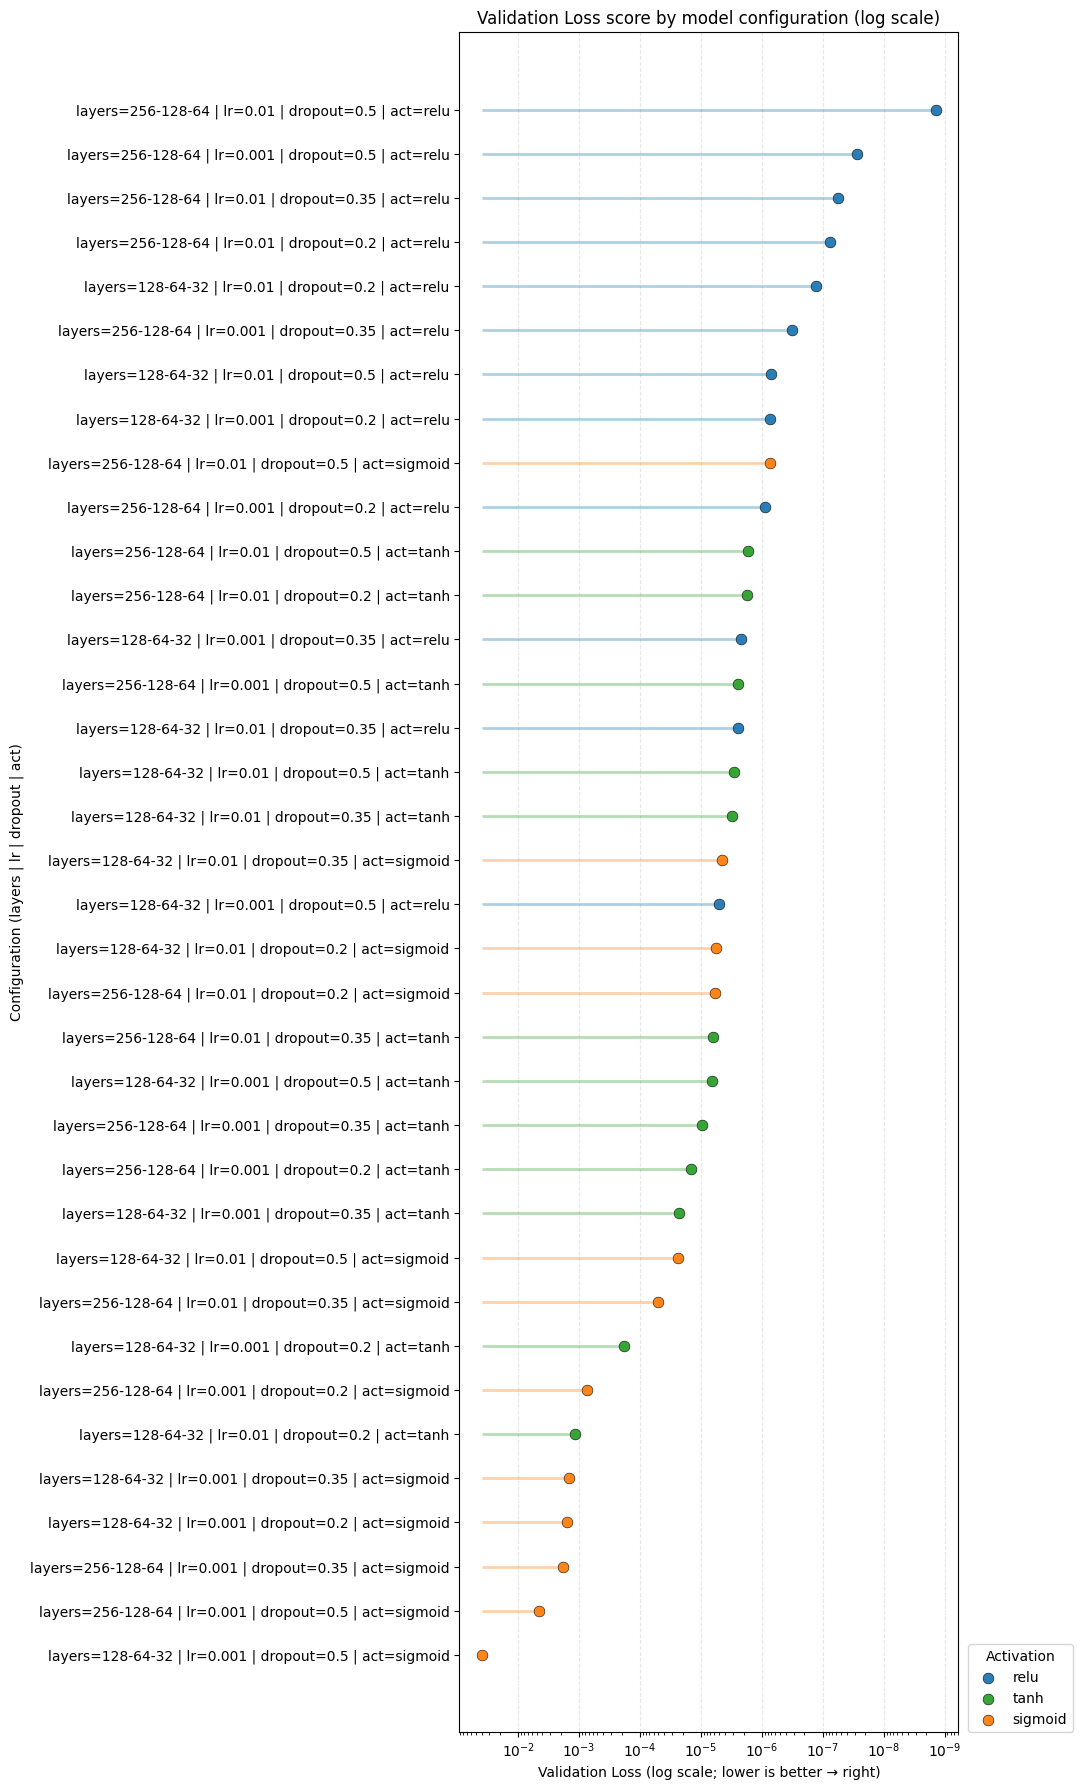

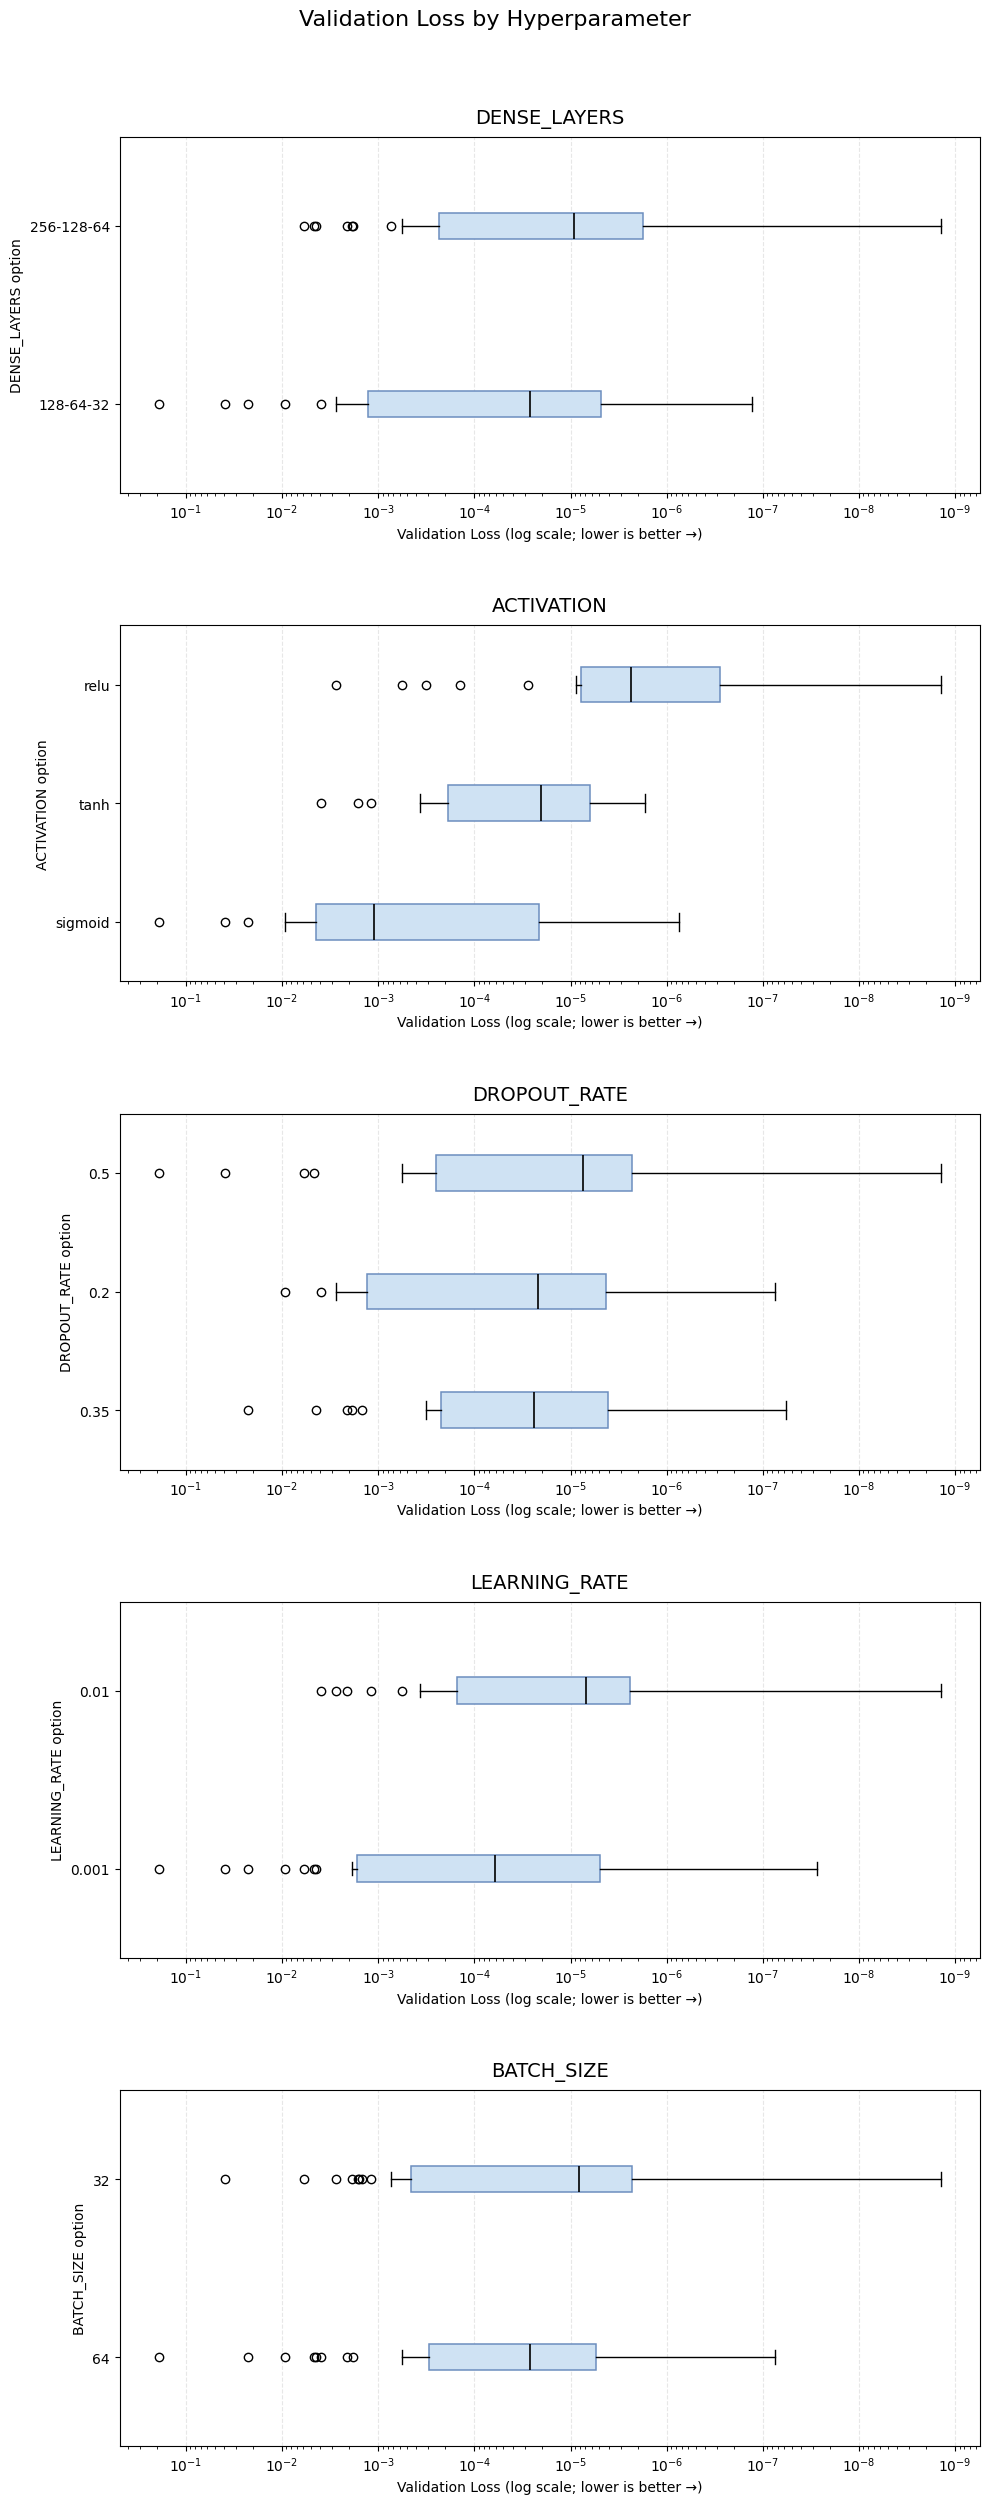

In [8]:
from src.gesture_controller.plot_helper import PlotHelper
from src.gesture_controller.app_config import AppConfig
import pandas as pd
import sys
import os

config = AppConfig()
paths = config.get_neural_network_config()
model_performance_path = paths.get('MODEL_PERFORMANCE_PATH')

df = pd.read_csv(model_performance_path)
plot_helper = PlotHelper()
plot_helper.plot_model_val_loss_score(df)
plot_helper.plot_val_loss_by_parameter(df)

<a id="evaluation"></a>
## 4. In-Depth Evaluation of the Best Model

Once the best-performing model has been identified from the hyperparameter search, we conduct a more detailed evaluation. This section focuses exclusively on the "winner" model to understand its learning dynamics, classification accuracy, and the structure of its predictions.

### Interpreting the Plots

The following code cell will generate several visualizations to assess the best model:

1.  **Training & Validation Curves (Loss and Accuracy)**: These plots show the model's loss and accuracy on both the training and validation sets over each epoch.
    *   **What to look for**: We want to see both curves converging. If the training loss/accuracy improves but the validation loss/accuracy stagnates or worsens, it's a sign of **overfitting**. A healthy model shows both curves improving and stabilizing.
2.  **Confusion Matrix**: This matrix provides a detailed breakdown of classification performance for each gesture.
    *   **How to read it**: The diagonal elements show the number of correct predictions for each class. Off-diagonal elements show where the model made mistakes (i.e., which gestures it confused with others). A perfect model would have a bright diagonal and dark off-diagonals.
3.  **ROC Curve (Receiver Operating Characteristic)**: This plot illustrates the diagnostic ability of the classifier as its discrimination threshold is varied.
    *   **What it means**: The Area Under the Curve (AUC) is a key metric. An AUC of 1.0 represents a perfect classifier, while an AUC of 0.5 represents a model with no discriminative power (equivalent to random guessing). We aim for curves that are pushed towards the top-left corner.
4.  **PCA and t-SNE Plots**: These are dimensionality reduction techniques used to visualize the high-dimensional landmark data in 2D.
    *   **What they show**: The plots show how the model's predictions cluster the data points. Well-separated clusters for each gesture indicate that the model has learned discriminative features and can distinguish between the classes effectively. Overlapping clusters may indicate which gestures are harder for the model to tell apart.

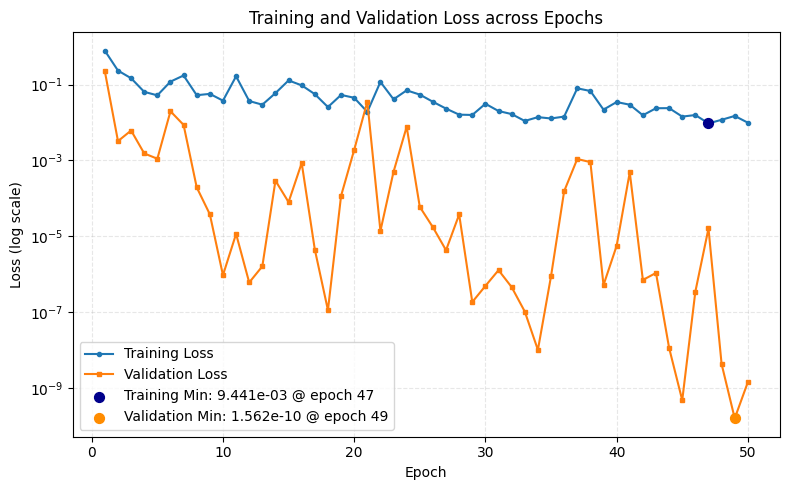

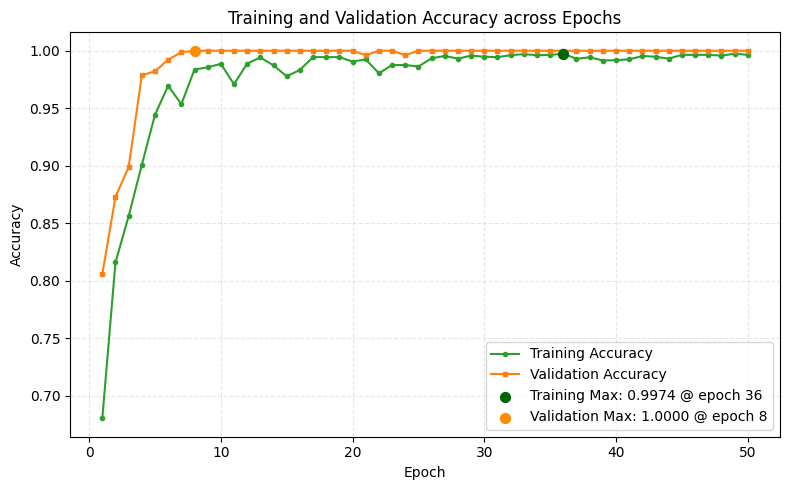

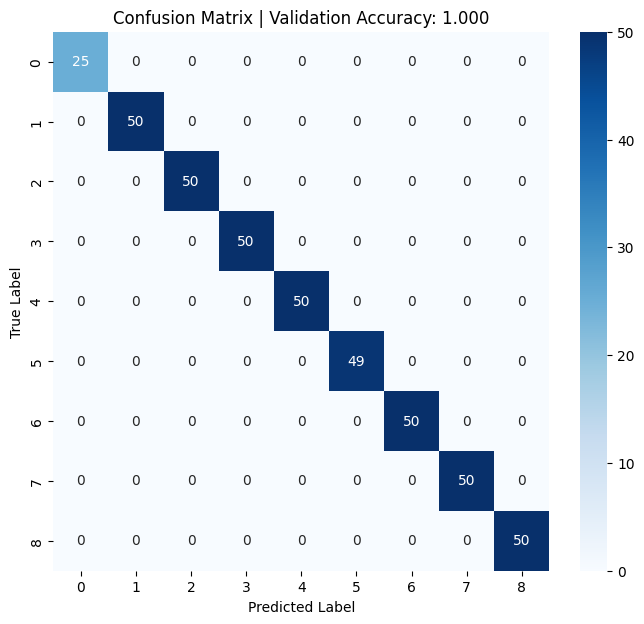

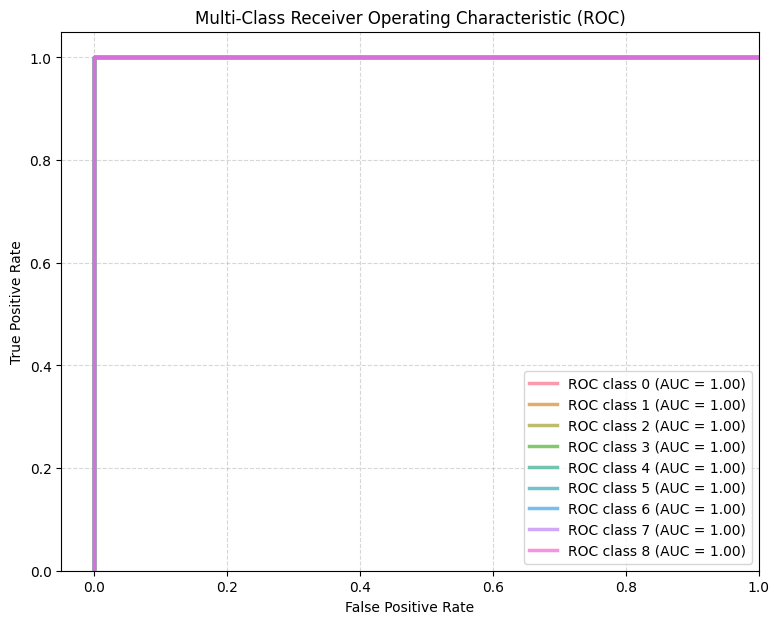

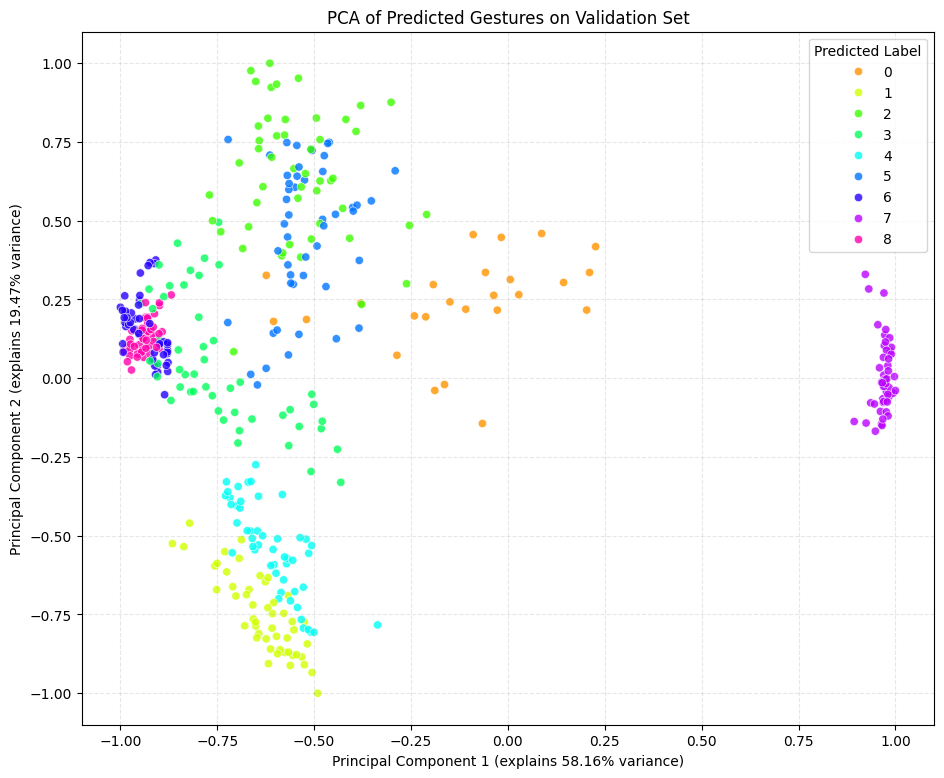

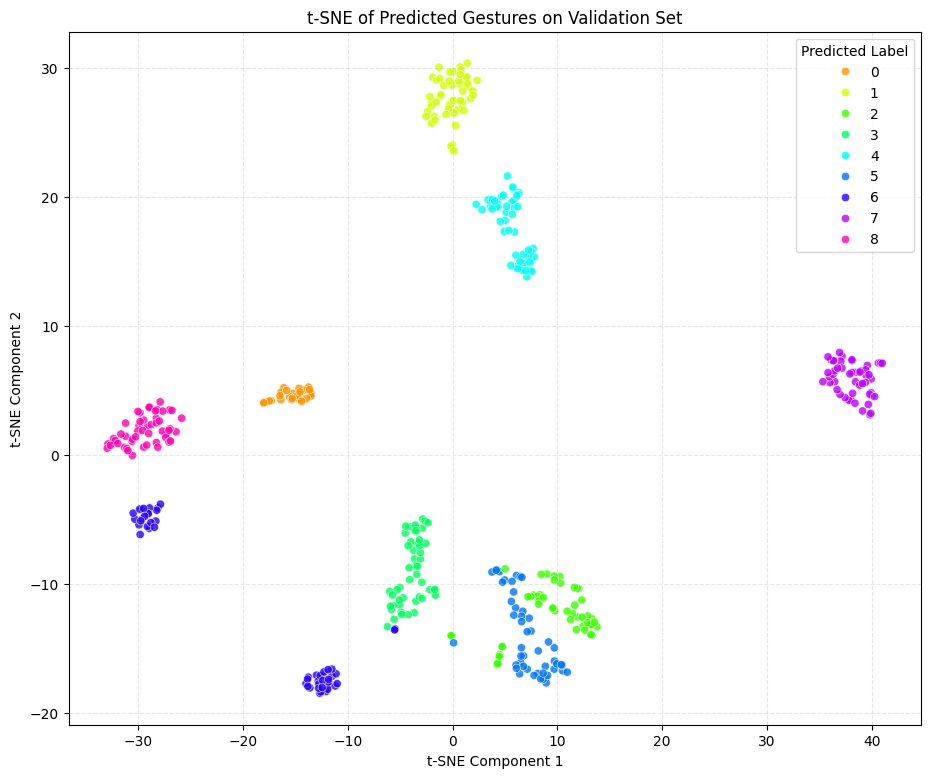

In [1]:
from src.gesture_controller.plot_helper import PlotHelper
from src.gesture_controller.app_config import AppConfig
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import sys
import os

# Resolve paths from config
config = AppConfig()

data_generation_config = config.get_app_config("DATA_GENERATION_CONFIG")
datase_val_path = data_generation_config.get("DATASET_VAL_PATH")

nn_config = config.get_neural_network_config()
model_path = nn_config.get('MODEL_PATH')
model_performance_path = nn_config.get('MODEL_PERFORMANCE_PATH')


df = pd.read_csv(model_performance_path)
winner = df.sort_values(by=['val_accuracy', 'val_loss'], ascending=[False, True]).iloc[0]
plot_helper = PlotHelper()
plot_helper.plot_loss_in_epochs(winner)
plot_helper.plot_accuracy_in_epochs(winner)


# Load dataset
df = pd.read_csv(datase_val_path)
df['LANDMARKS'] = df['LANDMARKS'].apply(eval)
X = np.array(df['LANDMARKS'].tolist())
Y = df['GESTURE_ID'].to_numpy()

# Load model and predict
model = tf.keras.models.load_model(model_path)
probs = model.predict(X, verbose=0)
y_pred = np.argmax(probs, axis=1)

# Confusion matrix plot
classes = np.unique(Y)
plot_helper.plot_heatmap(Y, y_pred, classes)

# ROC plot
plot_helper.plot_roc_curve(Y, probs, classes)

# PCA Visualization plot
plot_helper.plot_pca(X, y_pred)

# t-SNE Visualization plot
plot_helper.plot_tsne(X, y_pred)